In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import missingno as msno
from bokeh.core.properties import value
from bokeh.io import show,output_notebook
from bokeh.plotting import figure
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.layouts import row
import nltk
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment import SentimentAnalyzer 

pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_colwidth', -1) # @Qumeng: caused futerwarning
pd.set_option('display.max_rows', None)  
%matplotlib inline

In [2]:
script = pd.read_csv("script.csv",encoding='utf-8')
f = open('The Lord Of The Ring 1-The Fellowship Of The Ring_djvu.txt','r')
message = f.read()

In [3]:
#add a column count how many sentenses spoken by the character in total
script["count"] = script["char"].map(lambda x: script["char"].tolist().count(x) )
script = script.sort_values("count",ascending = False)
script.head()

,Unnamed: 0,char,dialog,movie,count
1832,1832,FRODO,"I can feel his blade. ,",The Return of the King,225
1689,1689,FRODO,Go!,The Fellowship of the Ring,225
2183,2183,FRODO,But I know you have something to do with it.,The Fellowship of the Ring,225
672,672,FRODO,"The Ring will not save Gondor. , It has only the power to destroy. Please......Iet me go.",The Two Towers,225
2185,2185,FRODO,Before you came along we Bagginses were very well thought of.,The Fellowship of the Ring,225


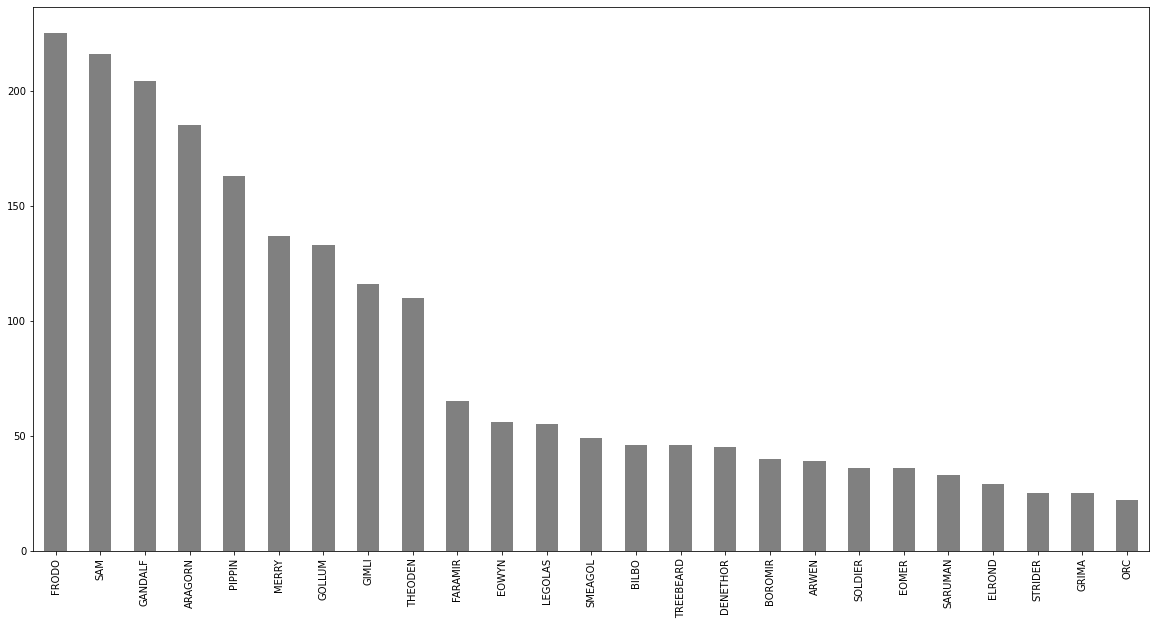

In [4]:
# sort by count, and draw bar chart shows the sentences spoken by different characters in total.
script1 = script[script["count"]>=22]
order = script1["char"].unique()
char = script1["char"]
a = char.value_counts()
a = a.sort_values(ascending = False)[0:50]
plt.figure(figsize=(20,10))
b = a.plot(kind = "bar",color = "grey")

In [5]:
#gourpby moives and characters
grouped = script1.groupby(['char',"movie"]).count()
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
grouped = grouped.reset_index()
grouped = grouped.iloc[:,:3]
grouped.columns = ["char","movie","count"]
grouped.head()
hue_order = np.array(["The Fellowship of the Ring","The Two Towers","The Return of the King"]).astype(object)

/tmp/ipykernel_230/2991079242.py:3: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]


/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


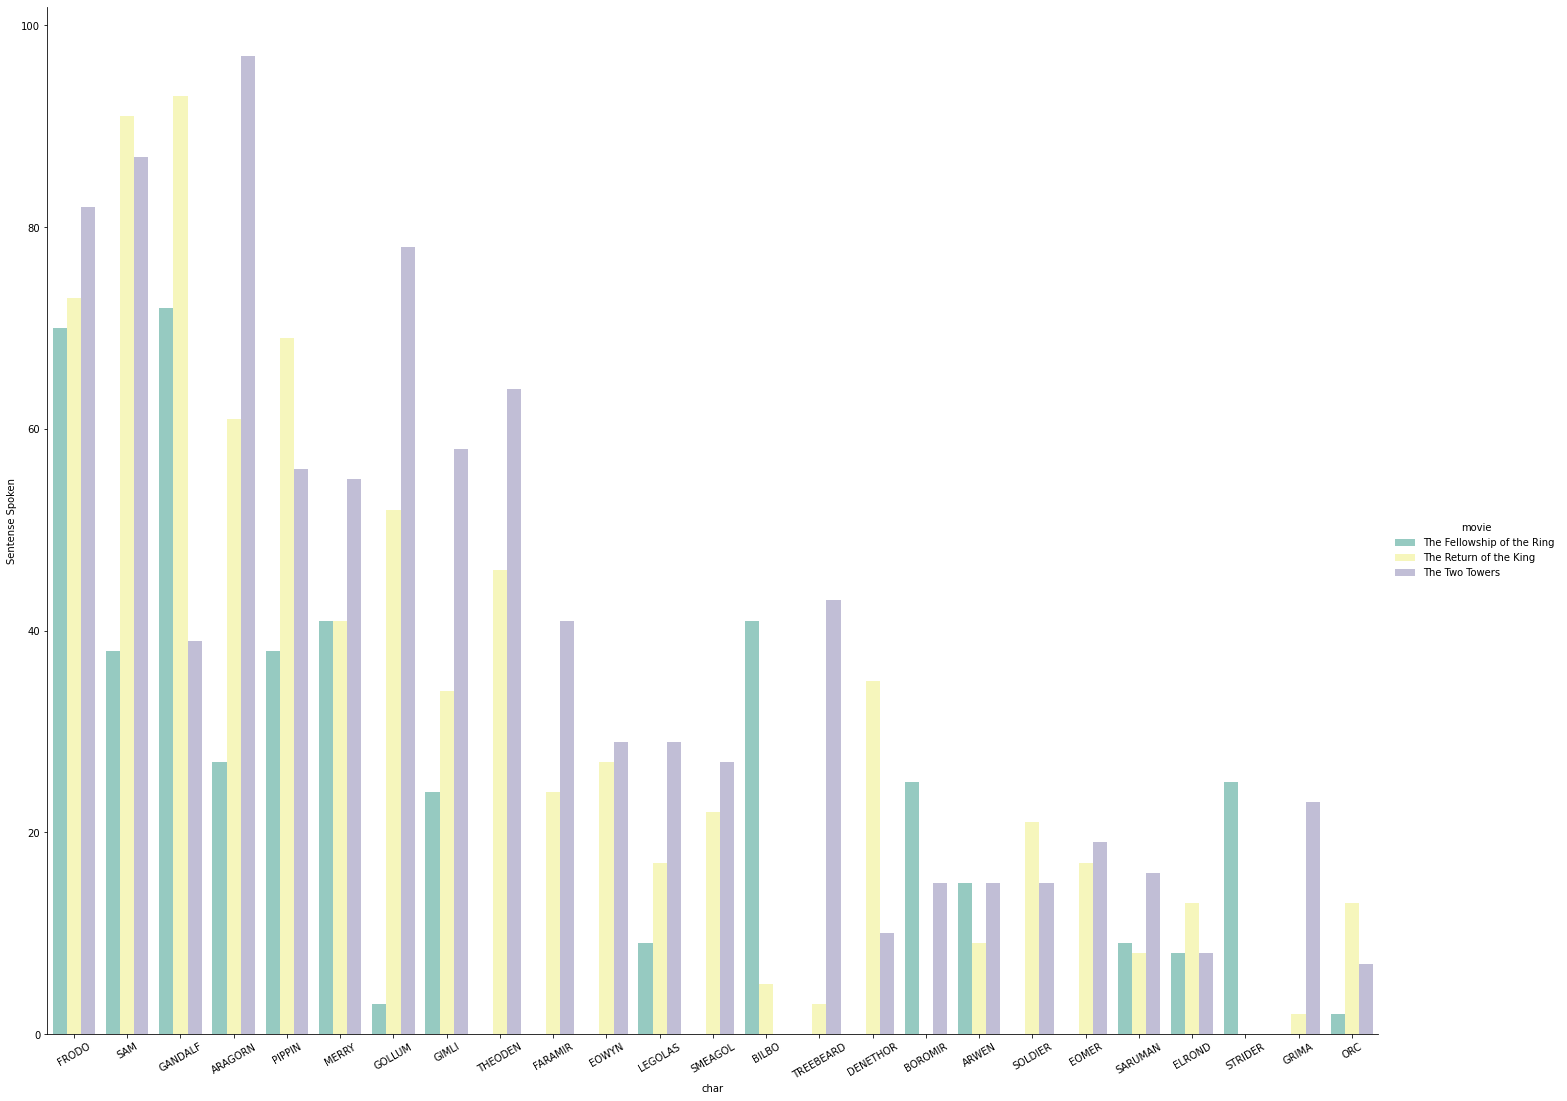

In [6]:
# draw bar chart shows the sentences spoken by different characters in different movies.
g = sns.factorplot(x="char", y="count", hue="movie", data=grouped,
                   size=15, aspect = 1.3, kind="bar", palette="Set3",order = order)
g.set_xticklabels(rotation=30)
#g.despine(left=True)
g.set_ylabels("Sentense Spoken") 

In [7]:
# change the format for  grouped data in order to draw plot below
movie = ["The Fellowship of the Ring ","The Two Towers ","The Return of the King "]
grouped["The Fellowship of the Ring"] = 0
grouped["The Two Towers"] = 0
grouped["The Return of the King"] = 0
for i in range(len(grouped["char"])):
        if grouped["movie"][i] == "The Fellowship of the Ring ":
            grouped["The Fellowship of the Ring"][i] = grouped["count"][i]
        elif grouped["movie"][i] == "The Two Towers ":
            grouped["The Two Towers"][i] = grouped["count"][i]
        else:
            grouped["The Return of the King"][i] = grouped["count"][i]
grouped = grouped.drop(['movie'], axis=1)
groupedd = grouped.groupby("char").agg({'The Fellowship of the Ring': [sum],
                                            'The Two Towers': [sum], "The Return of the King":[sum],"count":[sum]})
groupedd.columns = ["_".join(x) for x in groupedd.columns.ravel()]
groupedd = groupedd.reset_index()

/tmp/ipykernel_230/4064006647.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped["The Fellowship of the Ring"][i] = grouped["count"][i]
/tmp/ipykernel_230/4064006647.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped["The Return of the King"][i] = grouped["count"][i]
/tmp/ipykernel_230/4064006647.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped["The Two Towers"][i] = grouped["count"][i]
/tmp/ipykernel_230

In [8]:
# fancy circled bar char using bokeh (might not shown on github)
from collections import OrderedDict
from math import log, sqrt

import numpy as np
import pandas as pd
from six.moves import cStringIO as StringIO

from bokeh.plotting import figure, show, output_file
output_notebook()

drug_color = OrderedDict([
    ("The Fellowship of the Ring",   "#0d3362"),
    ("The Two Towers", "#c64737"),
    ("The Return of the King",     "black"  ),
])

gram_color = "#aeaeb8"
    
groupedd = groupedd.sort_values("count_sum",ascending = False).reset_index()
groupedd.columns = ["ind_","char","The Fellowship of the Ring","The Two Towers","The Return of the King","count_sum"]
df = groupedd

width = 800
height = 800
inner_radius = 90
outer_radius = 300 - 10

minr = sqrt(log(.001 * 1E4))
maxr = sqrt(log(1000 * 1E4))
a = (outer_radius - inner_radius) / (minr - maxr)
b = inner_radius - a * maxr

# def rad(mic):
#     return a * np.sqrt(np.log(mic * 1E4)) + b
def rad(mic):
     return mic/97 * 200 + 90

big_angle = 2.0 * np.pi / (len(df) + 1)
small_angle = big_angle / 7

p = figure(plot_width=width, plot_height=height, title="",
    x_axis_type=None, y_axis_type=None,
    x_range=(-420, 420), y_range=(-420, 420),
    min_border=0, outline_line_color="black",
    background_fill_color="#f0e1d2")

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# annular wedges
angles = np.pi/2 - big_angle/2 - df.index.to_series()*big_angle
colors = gram_color
p.annular_wedge(
    0, 0, inner_radius, outer_radius, -big_angle+angles, angles, color=colors,
)

# small wedges
p.annular_wedge(0, 0, inner_radius, rad(df['The Fellowship of the Ring']),
                -big_angle+angles+5*small_angle, -big_angle+angles+6*small_angle,
                color=drug_color['The Fellowship of the Ring'])
p.annular_wedge(0, 0, inner_radius, rad(df['The Two Towers']),
                -big_angle+angles+3*small_angle, -big_angle+angles+4*small_angle,
                color=drug_color['The Two Towers'])
p.annular_wedge(0, 0, inner_radius, rad(df['The Return of the King']),
                -big_angle+angles+1*small_angle, -big_angle+angles+2*small_angle,
                color=drug_color['The Return of the King'])

# circular axes and lables
labels = np.power(10.0, np.arange(-3, 4))
radii = a * np.sqrt(np.log(labels * 1E4)) + b
p.circle(0, 0, radius=radii, fill_color=None, line_color="white")
p.text(0, radii[:-1], [100,85,70,55,40,25,10],
       text_font_size="8pt", text_align="center", text_baseline="middle")

# radial axes
p.annular_wedge(0, 0, inner_radius-10, outer_radius+10,
                -big_angle+angles, -big_angle+angles, color="black")

# bacteria labels
xr = radii[0]*np.cos(np.array(-big_angle/2 + angles))
yr = radii[0]*np.sin(np.array(-big_angle/2 + angles))
label_angle=np.array(-big_angle/2+angles)
label_angle[label_angle < -np.pi/2] += np.pi 
p.text(xr, yr, df["char"], angle=label_angle,text_font_size="9pt", text_align="center", text_baseline="middle")



p.rect([-50, -50, -50], [18, 0, -18], width=25, height=13,
       color=list(drug_color.values()))
p.text([-35, -35, -35], [18, 0, -18], text=list(drug_color),
       text_font_size="7pt", text_align="left", text_baseline="middle")

#output_file("burtin.html", title="burtin.py example")

show(p)

Loading BokehJS ...

# Word Cloud

In [9]:
# clean the script data, delete useless symbols, save script by different characters

In [10]:
FRODO = script1[script1["char"]=="FRODO"]["dialog"].map(lambda x: x.replace(".","").replace("?","").replace("!","").replace(",","").split()).tolist()
SAM = script1[script1["char"]=="SAM"]["dialog"].map(lambda x: x.replace(".","").replace("?","").replace("!","").replace(",","").split()).tolist()
GANDALF = script1[script1["char"]=="GANDALF"]["dialog"].map(lambda x: x.replace(".","").replace("?","").replace("!","").replace(",","").split()).tolist()
ARAGORN = script1[script1["char"]=="ARAGORN"]["dialog"].map(lambda x: x.replace(".","").replace("?","").replace("!","").replace(",","").split()).tolist()
GOLLUM = script1[script1["char"]=="GOLLUM"]["dialog"].map(lambda x: x.replace(".","").replace("?","").replace("!","").replace(",","").split()).tolist()
SMEAGOL = script1[script1["char"]=="SMEAGOL"]["dialog"].map(lambda x: x.replace(".","").replace("?","").replace("!","").replace(",","").split()).tolist()
PIPPIN = script1[script1["char"]=="PIPPIN"]["dialog"].map(lambda x: x.replace(".","").replace("?","").replace("!","").replace(",","").split()).tolist()
MERRY = script1[script1["char"]=="MERRY"]["dialog"].map(lambda x: x.replace(".","").replace("?","").replace("!","").replace(",","").split()).tolist()
ARWEN = script1[script1["char"]=="ARWEN"]["dialog"].map(lambda x: x.replace(".","").replace("?","").replace("!","").replace(",","").split()).tolist()
ORC = script1[script1["char"]=="ORC"]["dialog"].map(lambda x: x.replace(".","").replace("?","").replace("!","").replace(",","").split()).tolist()


In [11]:
#split the script by each word, put them into one list for each character
FRODO_ = []
for i in FRODO:
    FRODO_ += i
SAM_ = []
for i in SAM:
    SAM_ += i
GANDALF_ = []
for i in GANDALF:
    GANDALF_ += i
ARAGORN_ = []
for i in ARAGORN:
    ARAGORN_ += i
SMEAGOL_ = []
for i in SMEAGOL:
    SMEAGOL_ += i
GOLLUM_ = []
for i in GOLLUM:
    GOLLUM_ += i
PIPPIN_ = []
for i in PIPPIN:
    PIPPIN_ += i
MERRY_ = []
for i in MERRY:
    MERRY_ += i
ARWEN_ = []
for i in ARWEN:
    ARWEN_ += i
ORC_ = []
for i in ORC:
    ORC_ += i

In [12]:
#set stop words
stopwords = set(STOPWORDS)
stopwords.add("said")

In [13]:
#Draw wordcloud for different characters, set characters' picture as its wordcloud's boundary

<Figure size 432x288 with 0 Axes>

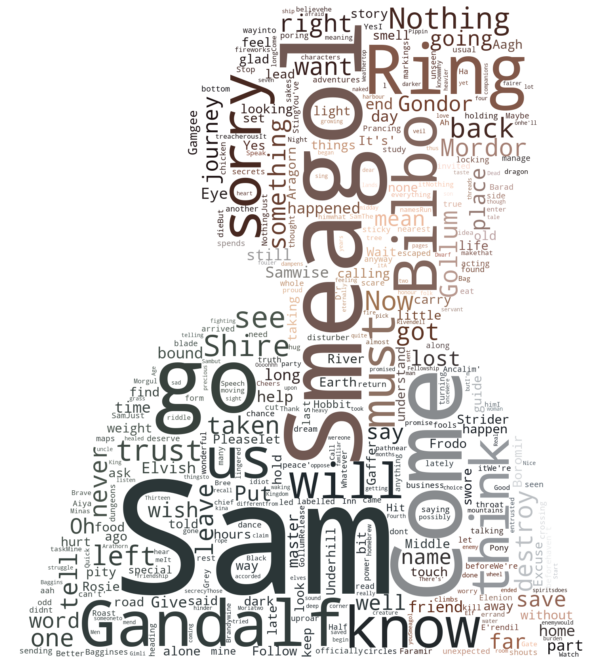

<Figure size 432x288 with 0 Axes>

In [14]:
FRODO_coloring = np.array(Image.open(path.join("img/frodo1.png")))
image_colors = ImageColorGenerator(FRODO_coloring)
wordcloud = WordCloud(background_color="white",max_words=2000,mask=FRODO_coloring,max_font_size=400).generate(' '.join(FRODO_))

plt.figure(figsize=(22,12))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()

<Figure size 432x288 with 0 Axes>

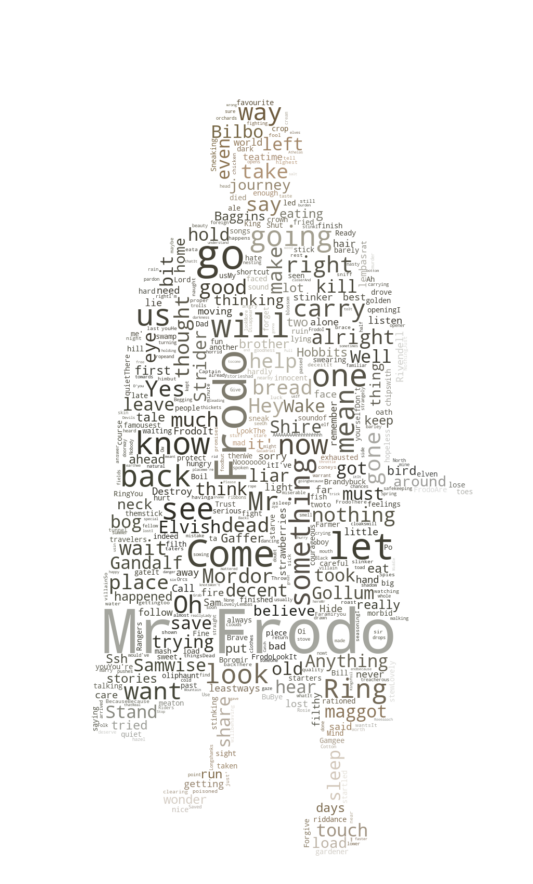

<Figure size 432x288 with 0 Axes>

In [15]:
SAM_coloring = np.array(Image.open(path.join("img/sam.png")))
image_colors = ImageColorGenerator(SAM_coloring)
wordcloud = WordCloud(background_color="white",max_words=2000,mask=SAM_coloring,max_font_size=400).generate(' '.join(SAM_))

plt.figure(figsize=(22,16))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()

In [16]:
GANDALF_coloring = np.array(Image.open(path.join("GANDALF.png")))
image_colors = ImageColorGenerator(GANDALF_coloring)
wordcloud = WordCloud(background_color="white",max_words=2000,mask=GANDALF_coloring,max_font_size=400).generate(' '.join(GANDALF_))

plt.figure(figsize=(22,16))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()

FileNotFoundError: [Errno 2] No such file or directory: 'GANDALF.png'

In [ ]:
ARAGORN_coloring = np.array(Image.open(path.join("ARAGORN.png")))
image_colors = ImageColorGenerator(ARAGORN_coloring)
wordcloud = WordCloud(background_color="white",max_words=2000,mask=ARAGORN_coloring,min_font_size=4,max_font_size=400).generate(' '.join(ARAGORN_))

plt.figure(figsize=(22,16))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()

In [ ]:
GOLLUM_coloring = np.array(Image.open(path.join("GOLLUM.png")))
image_colors = ImageColorGenerator(GOLLUM_coloring)
wordcloud = WordCloud(background_color="white",max_words=2000,mask=GOLLUM_coloring,min_font_size=4,max_font_size=400).generate(' '.join(GOLLUM_))

plt.figure(figsize=(22,16))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()

In [ ]:
SMEAGOL_coloring = np.array(Image.open(path.join("GOLLUM.png")))
image_colors = ImageColorGenerator(SMEAGOL_coloring)
wordcloud = WordCloud(background_color="white",max_words=2000,mask=SMEAGOL_coloring,min_font_size=4,max_font_size=400).generate(' '.join(SMEAGOL_))

plt.figure(figsize=(22,16))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()

# Sentiment Analysis

In [ ]:
#clean the data, little bit different from the last time
FRODO1 =script1[script1["char"]=="FRODO"]["dialog"].map(lambda x : x.replace(" ,","")).reset_index(drop=True).tolist()
SAM1 =script1[script1["char"]=="SAM"]["dialog"].map(lambda x : x.replace(" ,","")).reset_index(drop=True).tolist()
GANDALF1 =script1[script1["char"]=="GANDALF"]["dialog"].map(lambda x : x.replace(" ,","")).reset_index(drop=True).tolist()
ARAGORN1 =script1[script1["char"]=="ARAGORN"]["dialog"].map(lambda x : x.replace(" ,","")).reset_index(drop=True).tolist()
GOLLUM1 =script1[script1["char"]=="GOLLUM"]["dialog"].map(lambda x : x.replace(" ,","")).reset_index(drop=True).tolist()
SMEAGOL1 =script1[script1["char"]=="SMEAGOL"]["dialog"].map(lambda x : x.replace(" ,","")).reset_index(drop=True).tolist()
PIPPIN1 =script1[script1["char"]=="PIPPIN"]["dialog"].map(lambda x : x.replace(" ,","")).reset_index(drop=True).tolist()
MERRY1 =script1[script1["char"]=="MERRY"]["dialog"].map(lambda x : x.replace(" ,","")).reset_index(drop=True).tolist()
ARWEN1 =script1[script1["char"]=="ARWEN"]["dialog"].map(lambda x : x.replace(" ,","")).reset_index(drop=True).tolist()
ORC1 =script1[script1["char"]=="ORC"]["dialog"].map(lambda x : x.replace(" ,","")).reset_index(drop=True).tolist()

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score

In [ ]:
#generate a dictonary that make printing out the resault esiear.
charlist = {"FRODO":FRODO1,"SAM":SAM1,"GANDALF":GANDALF1, "ARAGORN": ARAGORN1,"GOLLUM": GOLLUM1, "SMEAGOL":SMEAGOL1,"PIPPIN":PIPPIN1,'MERRY':MERRY1,"ARWEN":ARWEN1}

In [ ]:
#sentiment analysis
def sentimentA(char):
    vader = SentimentIntensityAnalyzer()
    res_dic = [vader.polarity_scores(text) for text in charlist[char]]
    res_dic = [res_dic[i] for i in range(len(res_dic)) if res_dic[i]["compound"]!=0]
    res_neg = np.mean([res_dic[i]['neg'] for i in range(len(res_dic))])
    res_pos = np.mean([res_dic[i]['pos'] for i in range(len(res_dic))])
    res_com = np.mean([res_dic[i]['compound'] for i in range(len(res_dic))])
    print(char+":", res_com)    

In [ ]:
for i in charlist:
    sentimentA(i)